In [1]:
import pandas as pd
from pathlib import Path
transcript_dir = Path("/work/pi_vcpartridge_umass_edu/ytb_csv/")
df = pd.read_csv(transcript_dir / "transcripts_normalized.csv", header=0)
df.dropna(subset=["transcript"], inplace=True)
df.head()

video_id                                         transcript
0  AAHiZ-c88ec  man im getting frustrated water heater deliver...
1  AEsRr-ZnzNc  start give shout rokukun vyonder harrystack go...
2  AJpzk-aFZPU  10 minute test number exploding apple alright ...
3  AONXX-h9SdI  gonna play something brand new album came octo...
5  APerX-RLJxo  2010 toyota corolla fourdoor sedan automatic t...

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
import numpy as np

def get_bow_features(df: pd.DataFrame) -> np.ndarray:
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(df["transcript"])
    return X

def get_kmeans_clusters(X: np.ndarray, n_clusters: int = 10):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(X)
    return kmeans

def cluster_transcripts(df: pd.DataFrame, n_clusters: int = 10):
    X = get_bow_features(df)
    kmeans = get_kmeans_clusters(X, n_clusters)
    return kmeans

In [3]:
clusters_sizes = list(range(10, 51))
df_all = df.copy()
df_less_than_100 = df[df["transcript"].str.split().str.len() < 100]
df_more_than_100 = df[df["transcript"].str.split().str.len() > 100]

df_corporas = [df_all, df_less_than_100, df_more_than_100]
print(df_corporas[0].shape)
print(df_corporas[1].shape)
print(df_corporas[2].shape)


(2316, 2)
(1142, 2)
(1166, 2)


In [4]:
from tqdm import tqdm
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# fit kmeans for each corpus, for each number of clusters
# calculate inertia, silhouette_score, davies_bouldin_score, calinski_harabasz_score for each run
measures = []
measures.append([]) # all
measures.append([]) # less than 100
measures.append([]) # more than 100

kms = [[], [], []] # all, less than 100, more than 100

for n_clusters in tqdm(clusters_sizes):
    for i, df_corpus in enumerate(df_corporas):
        km = cluster_transcripts(df_corpus, n_clusters)
        kms[i].append(km)
        X = get_bow_features(df_corpus)
        measures[i].append({
            "n_clusters": n_clusters,
            "inertia": km.inertia_,
            "silhouette_score": silhouette_score(X, km.labels_),
            "davies_bouldin_score": davies_bouldin_score(X.toarray(), km.labels_),
            "calinski_harabasz_score": calinski_harabasz_score(X.toarray(), km.labels_)
        })

100%|██████████| 41/41 [03:15<00:00,  4.76s/it]


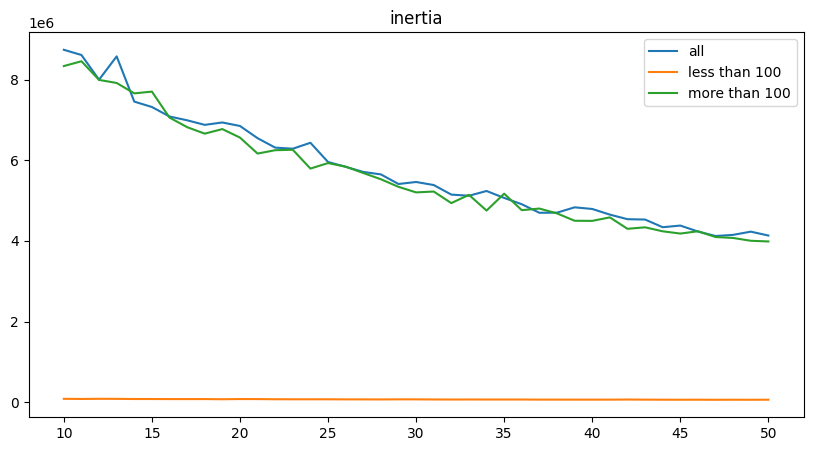

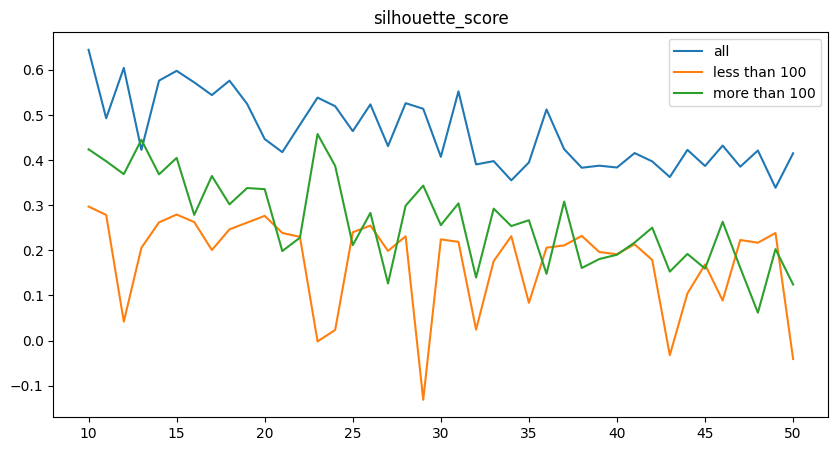

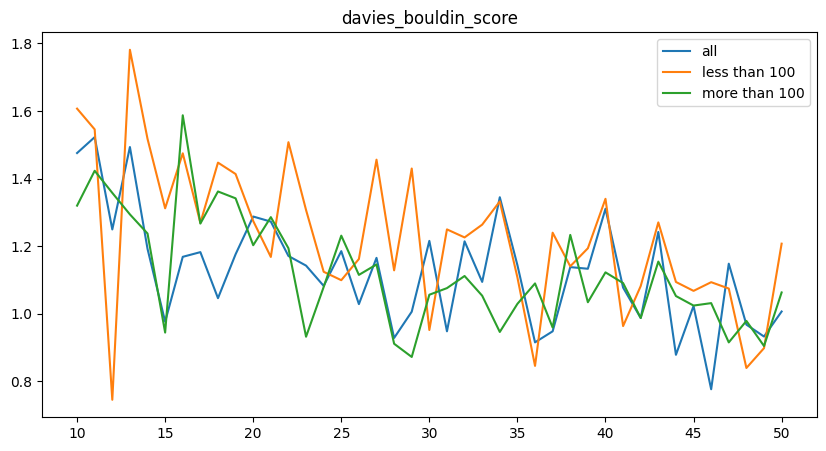

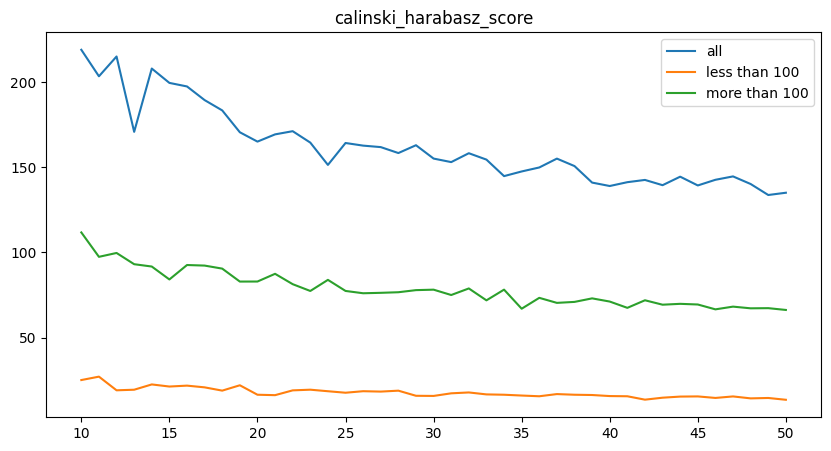

In [5]:
# plot measures for the same corpus, for different number of clusters
import matplotlib.pyplot as plt

plot_attributes = ["inertia", "silhouette_score", "davies_bouldin_score", "calinski_harabasz_score"]
labels = ["all", "less than 100", "more than 100"]
for attribute in plot_attributes:
    plt.figure(figsize=(10, 5))
    for i, df_corpus in enumerate(df_corporas):
        plt.plot(clusters_sizes, [m[attribute] for m in measures[i]], label=labels[i])
        plt.title(attribute)
    plt.legend()
    plt.show()

# inertia: lower better
# silhouette_score: higher better
# davies_bouldin_score: lower better
# calinski_harabasz_score: higher better

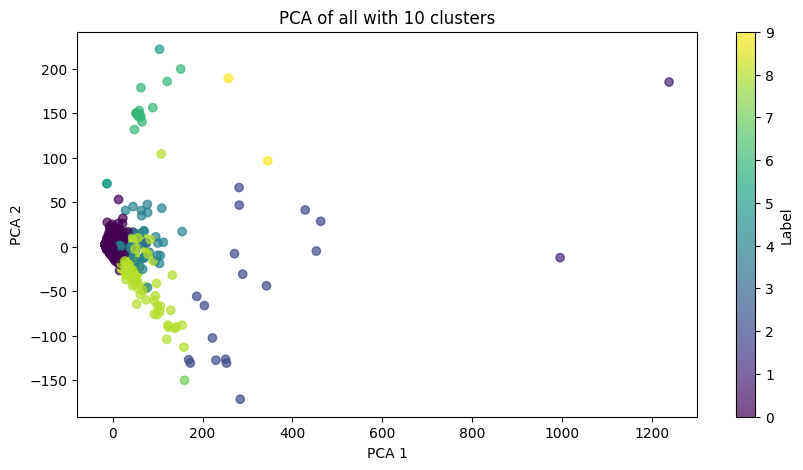

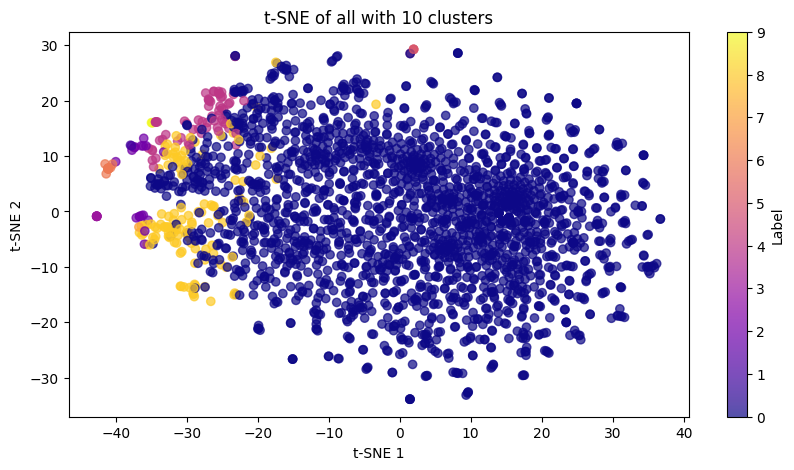

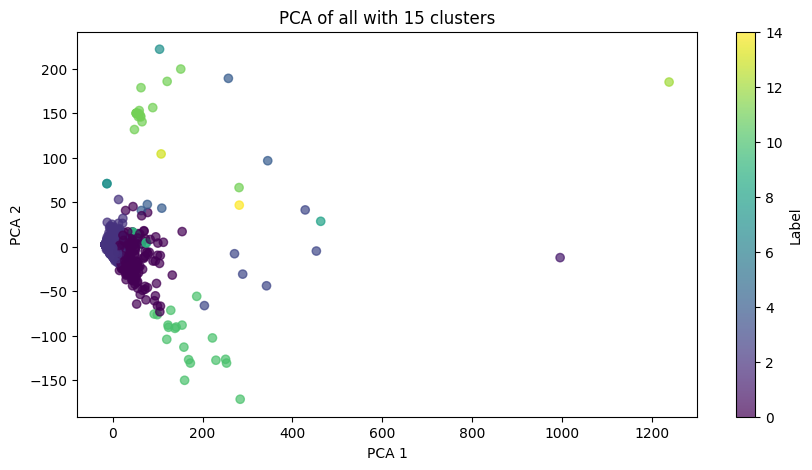

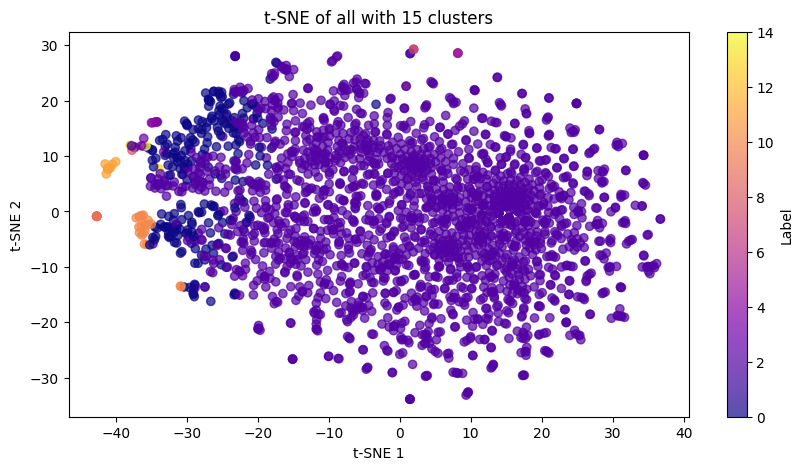

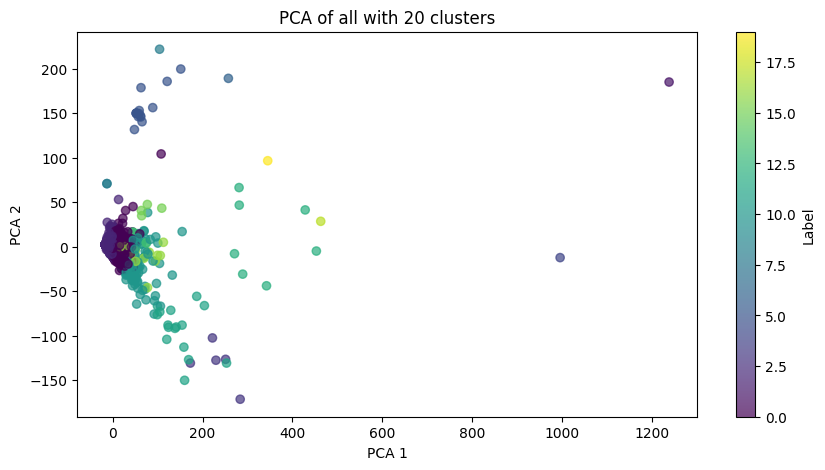

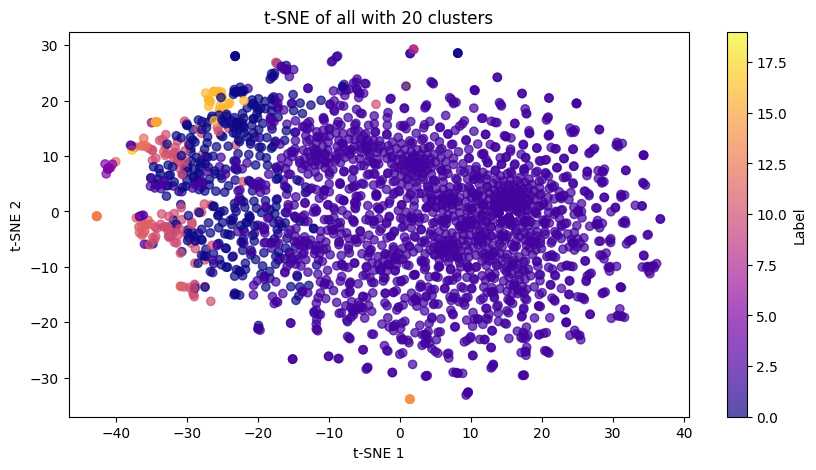

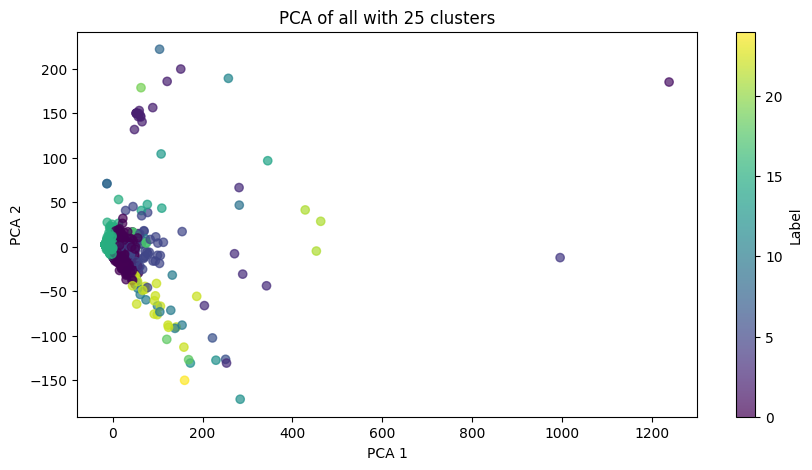

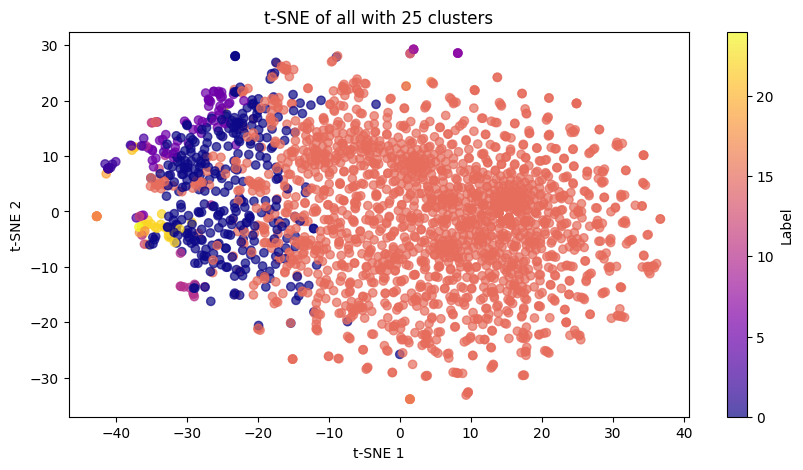

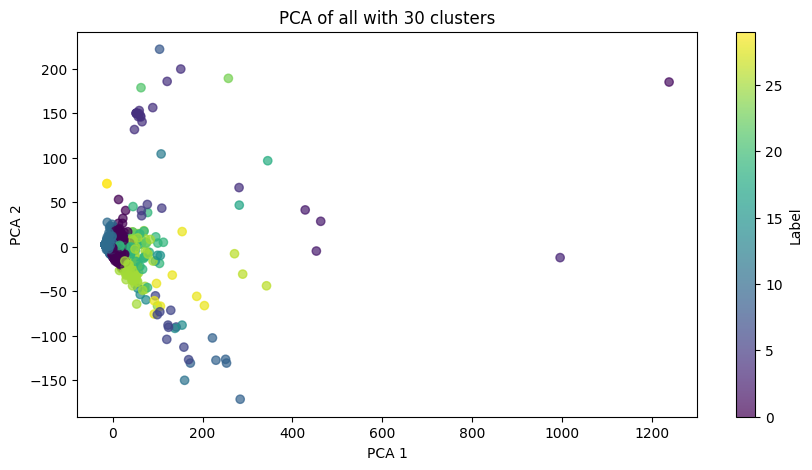

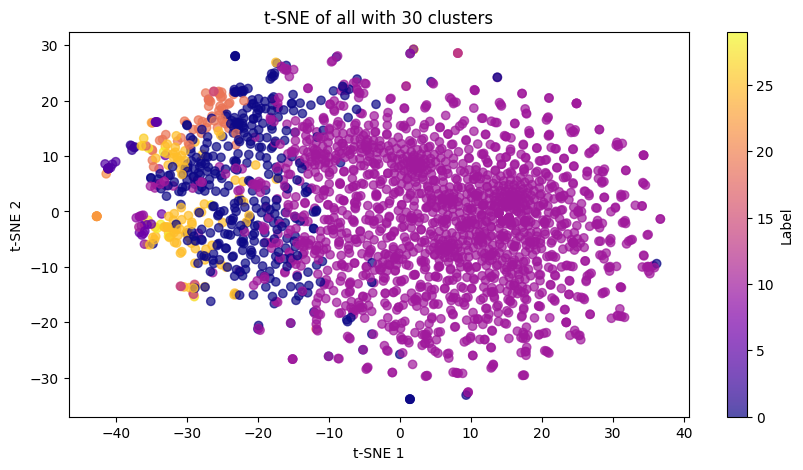

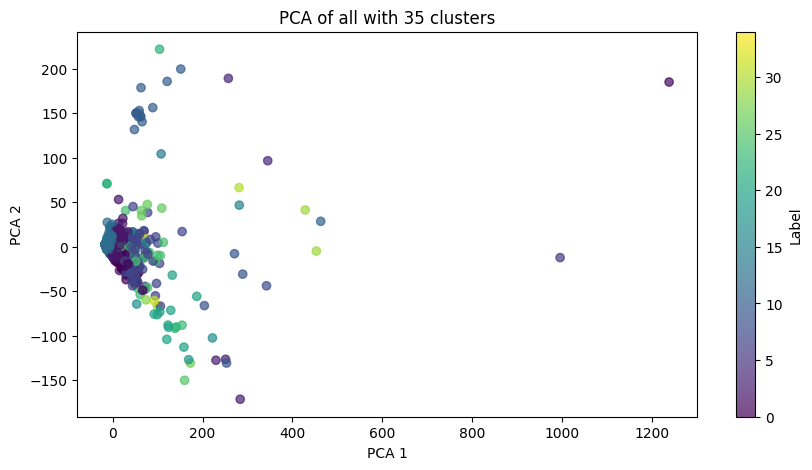

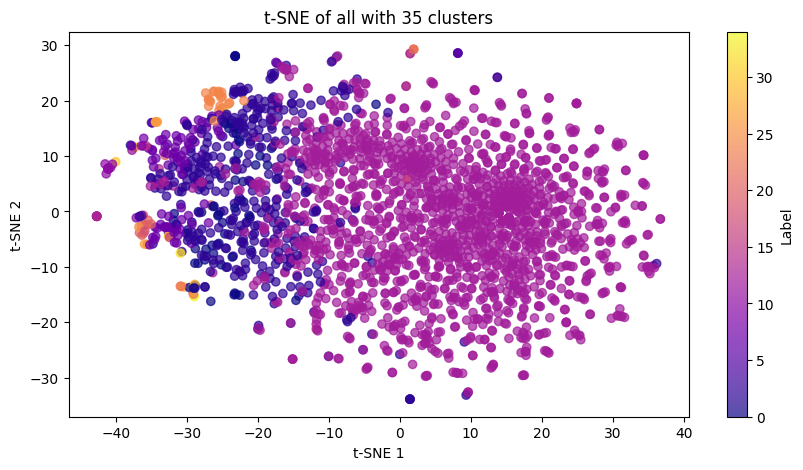

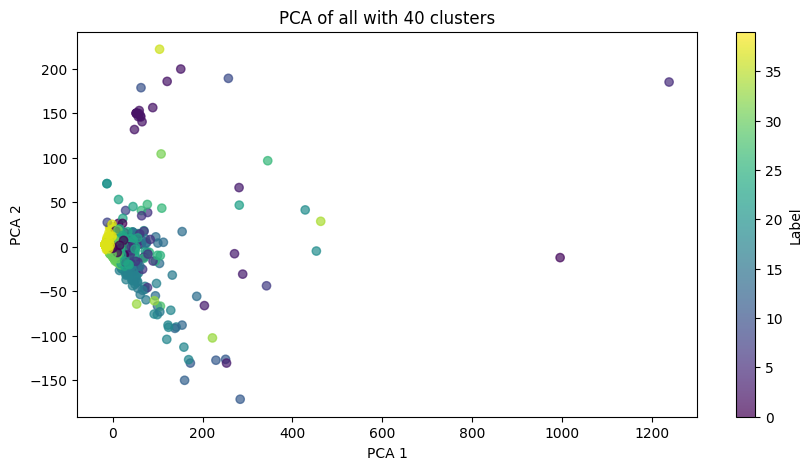

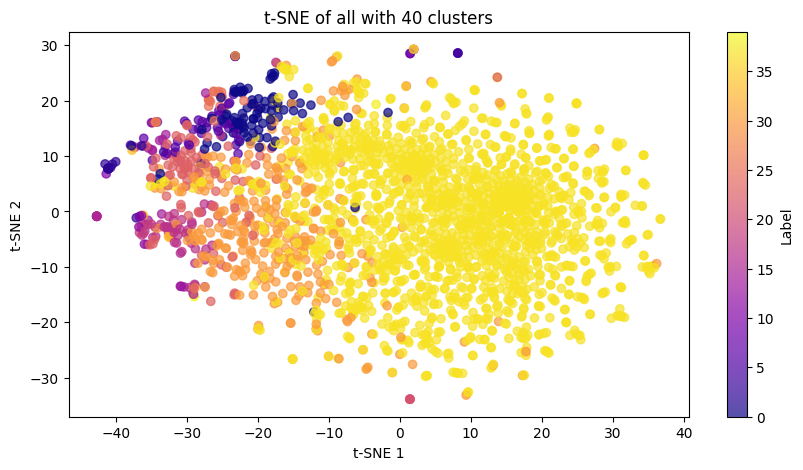

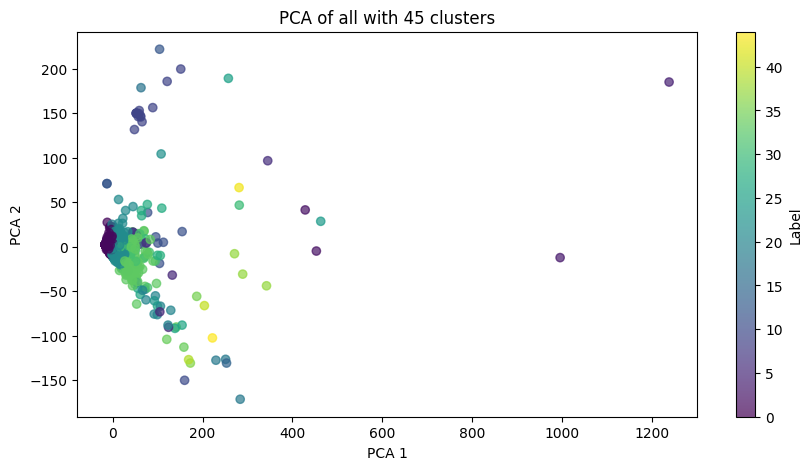

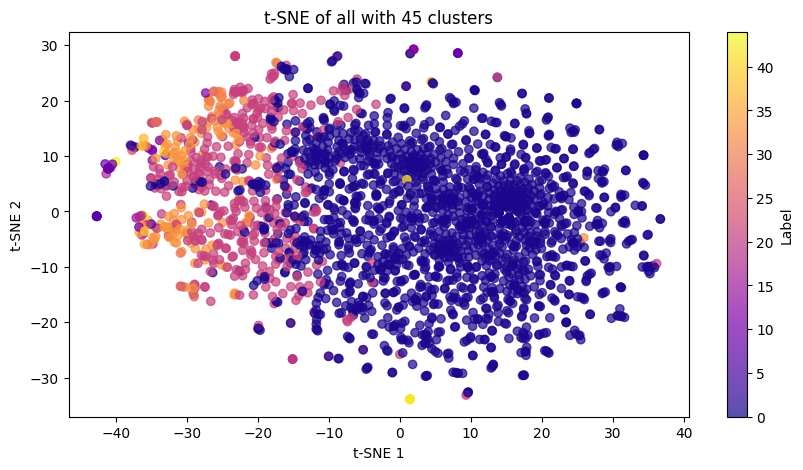

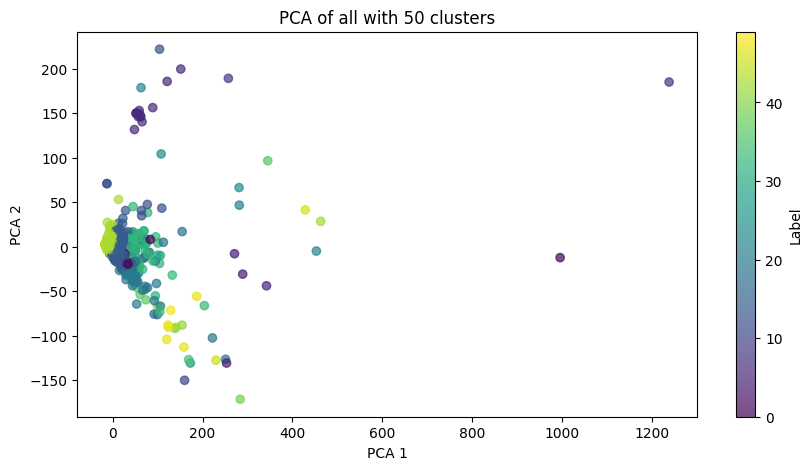

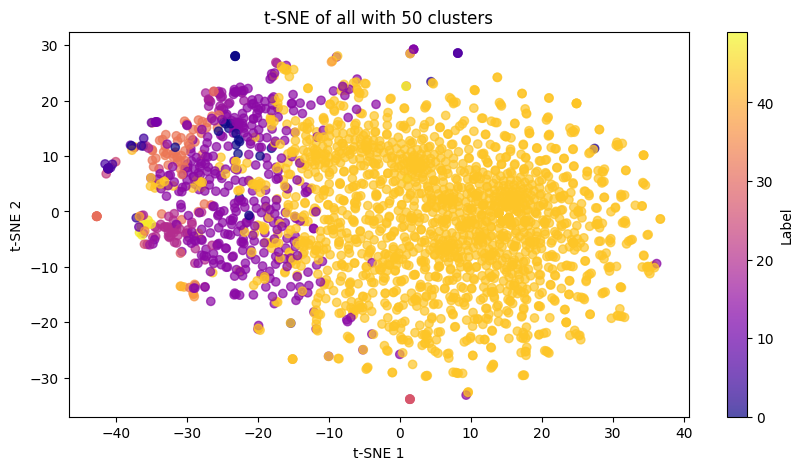

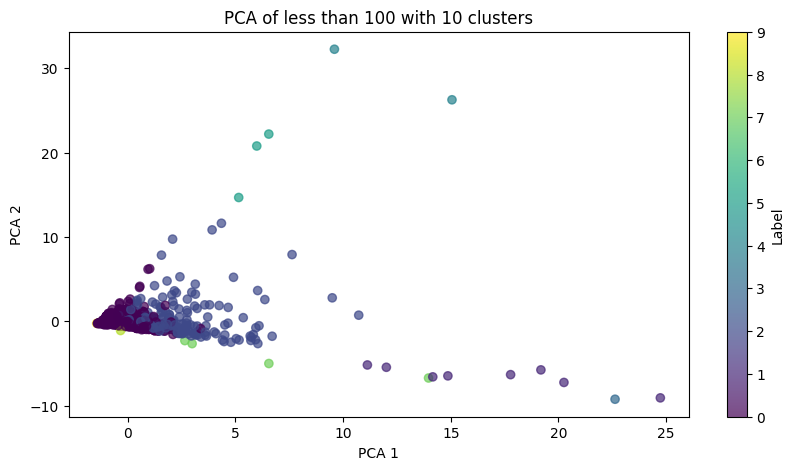

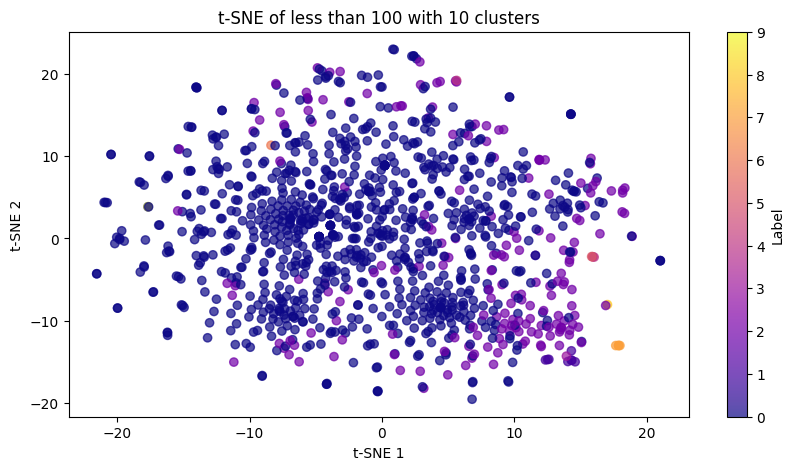

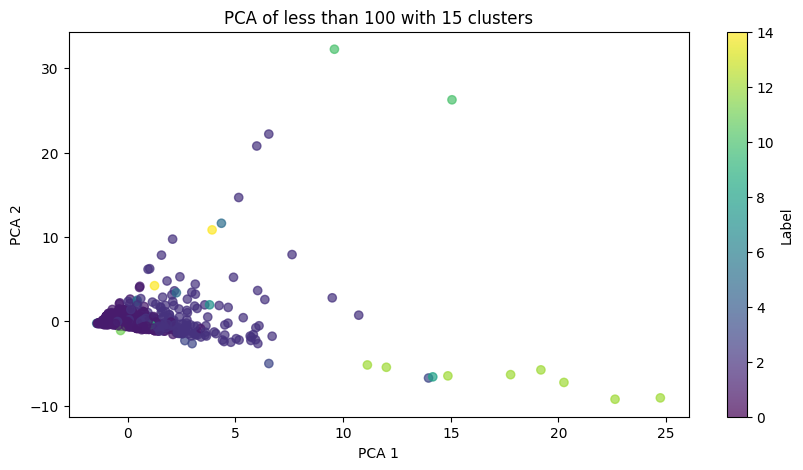

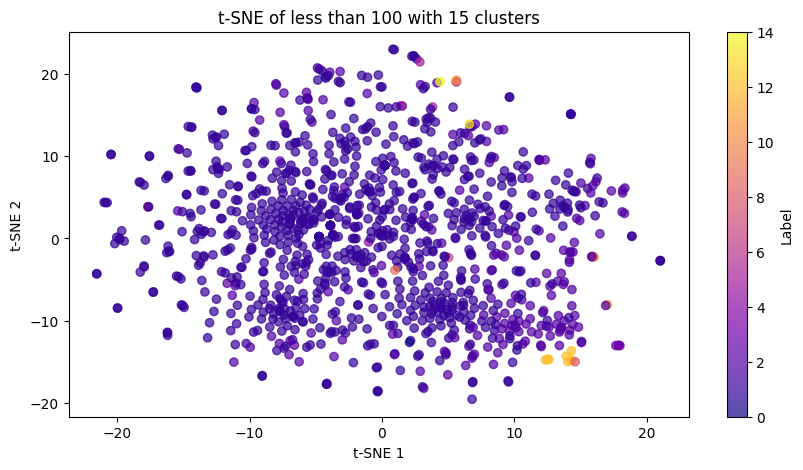

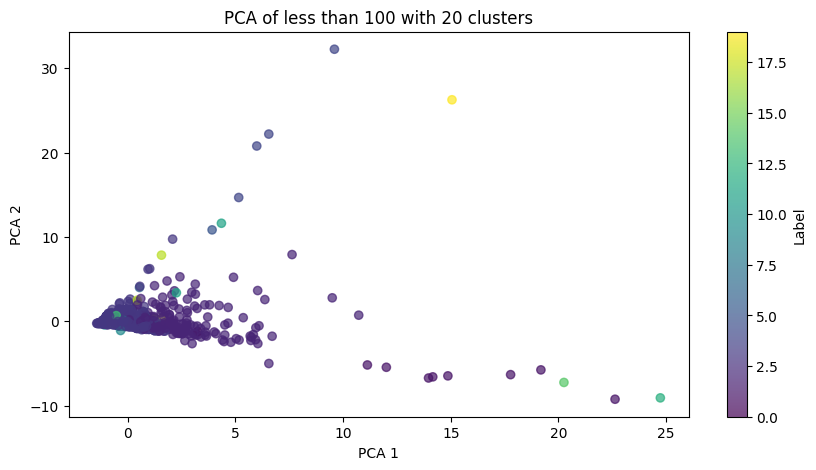

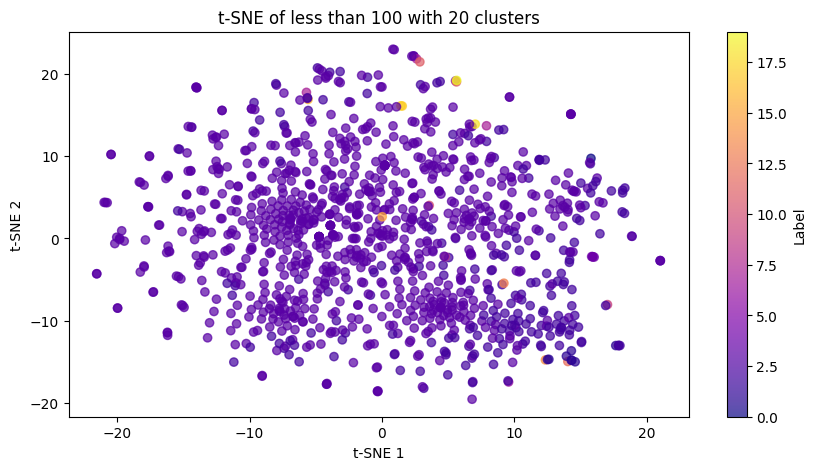

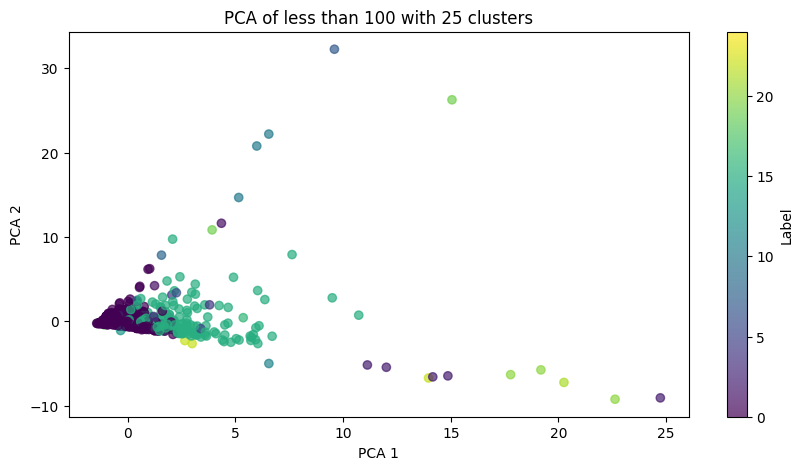

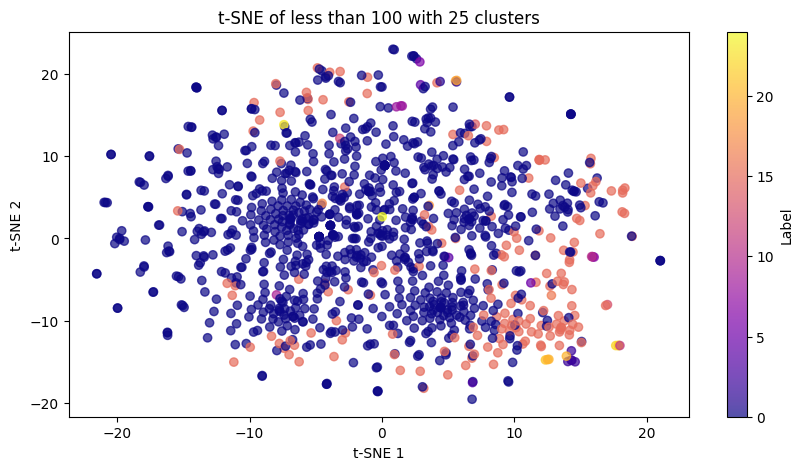

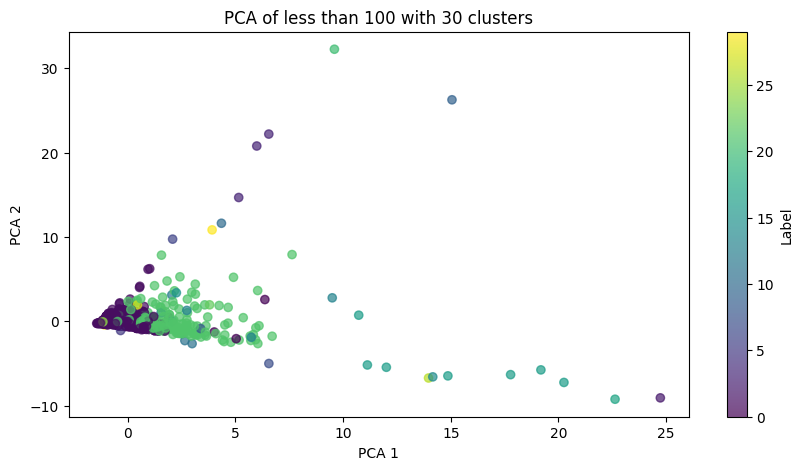

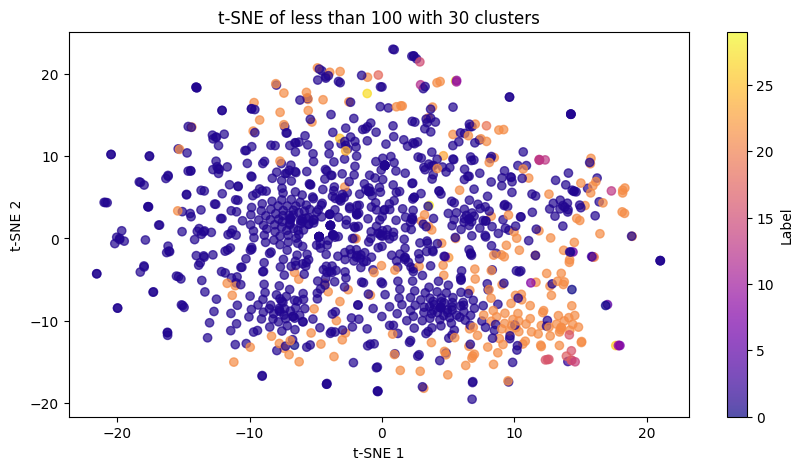

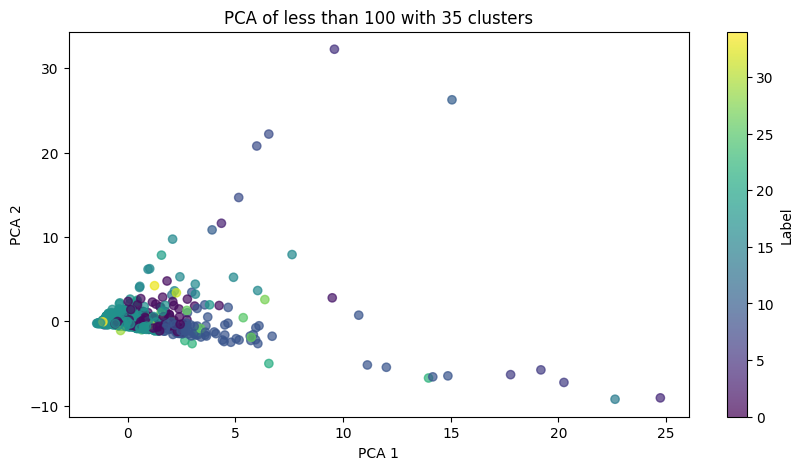

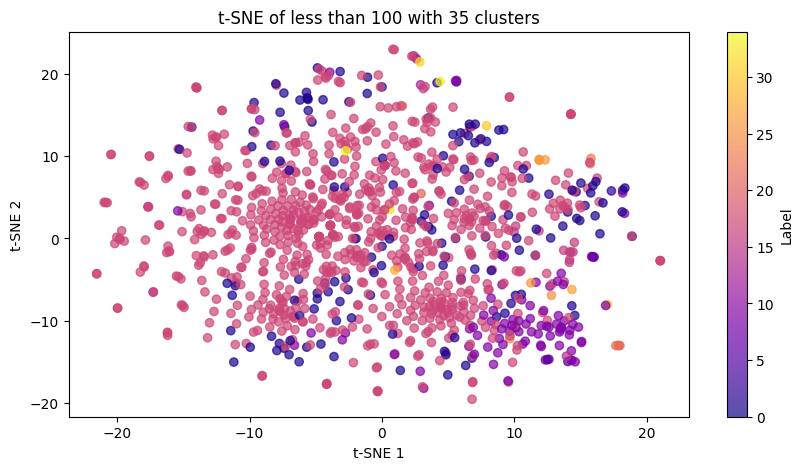

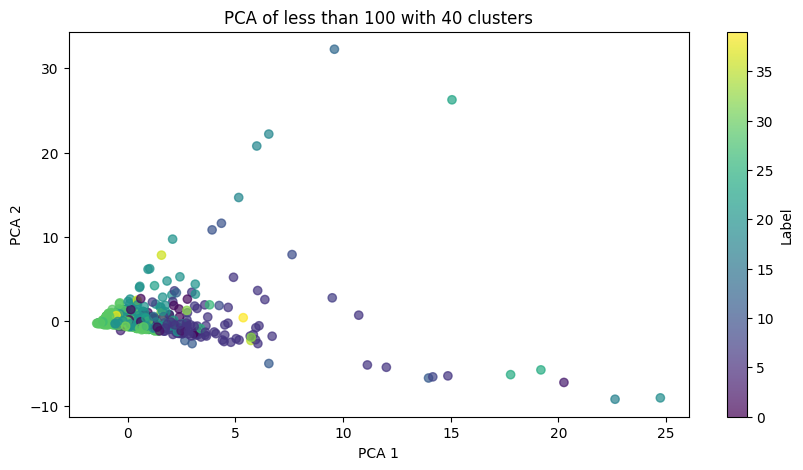

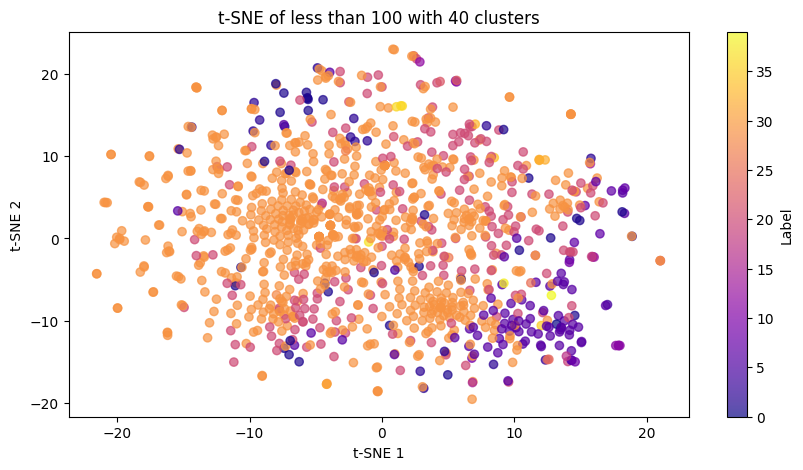

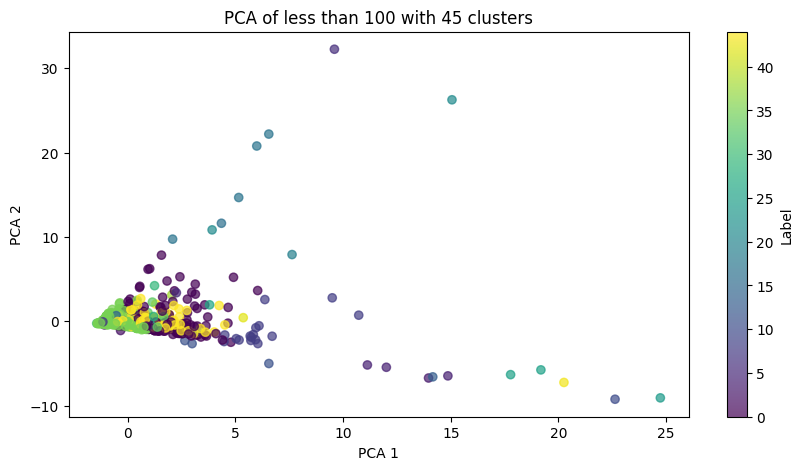

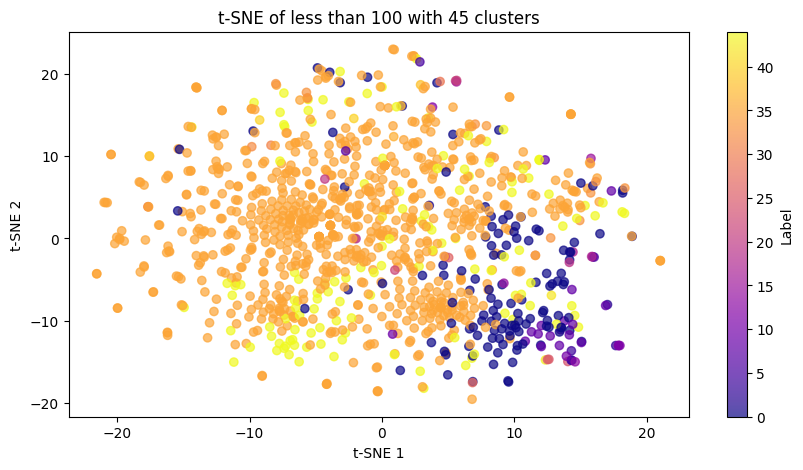

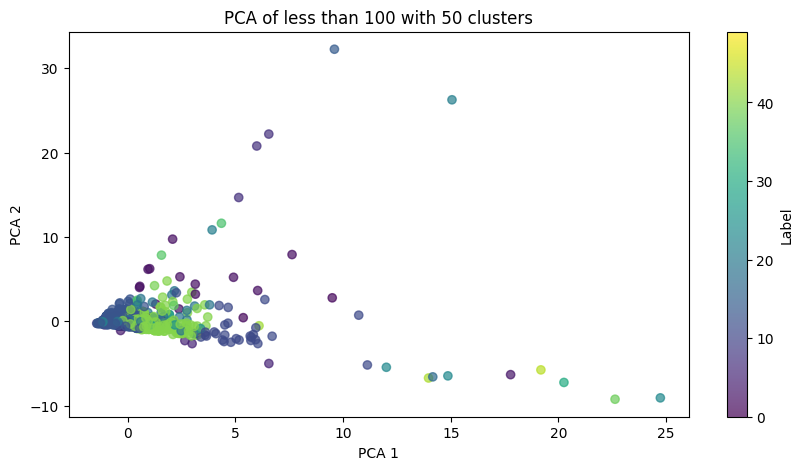

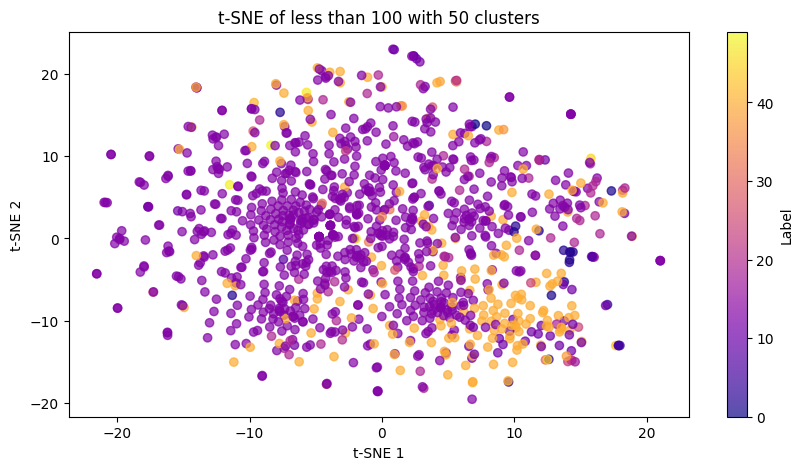

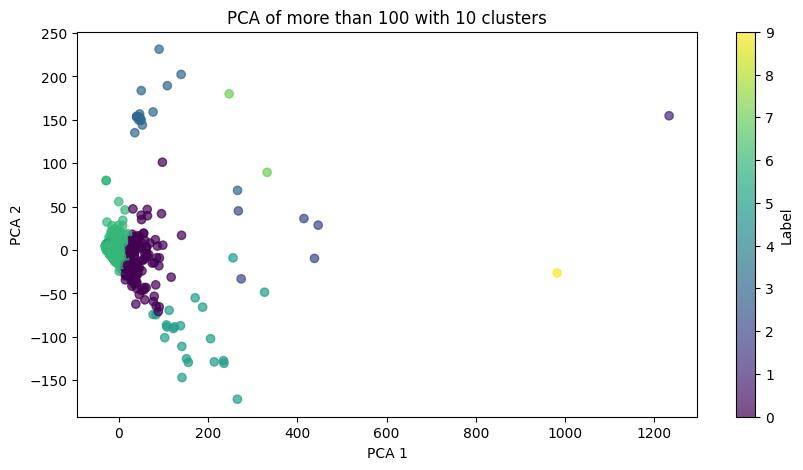

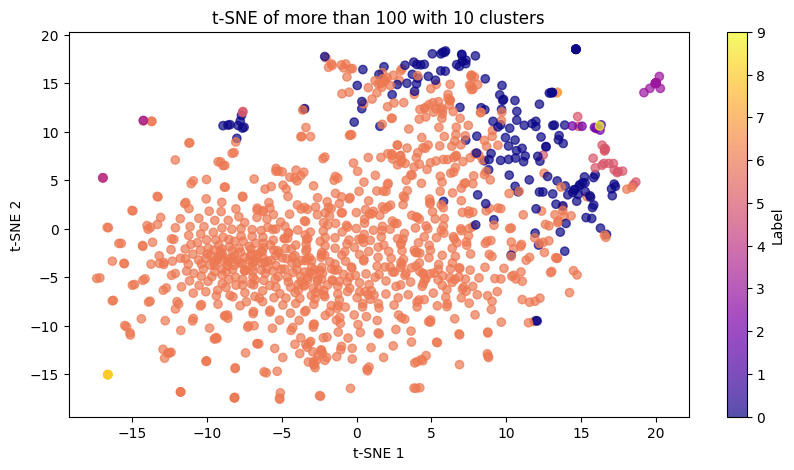

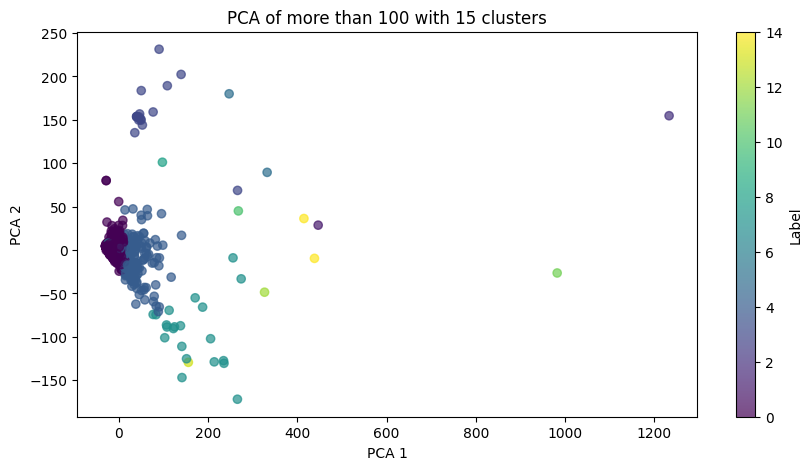

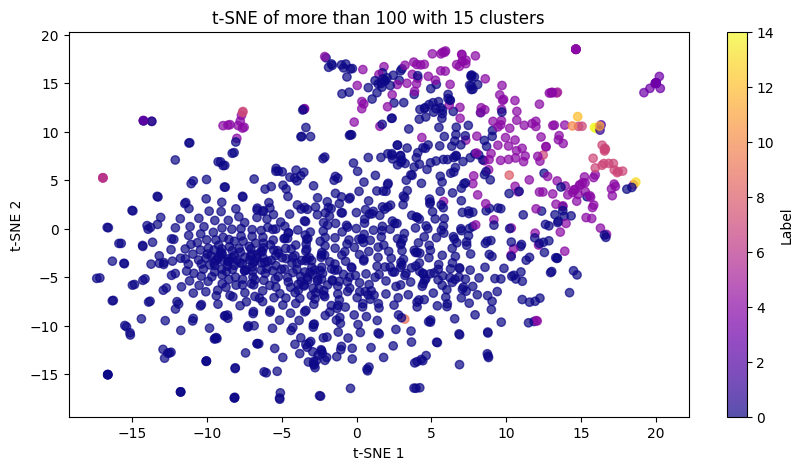

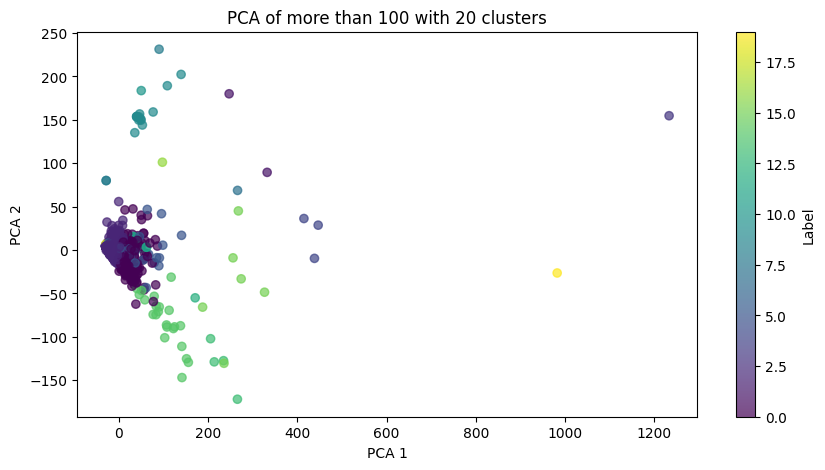

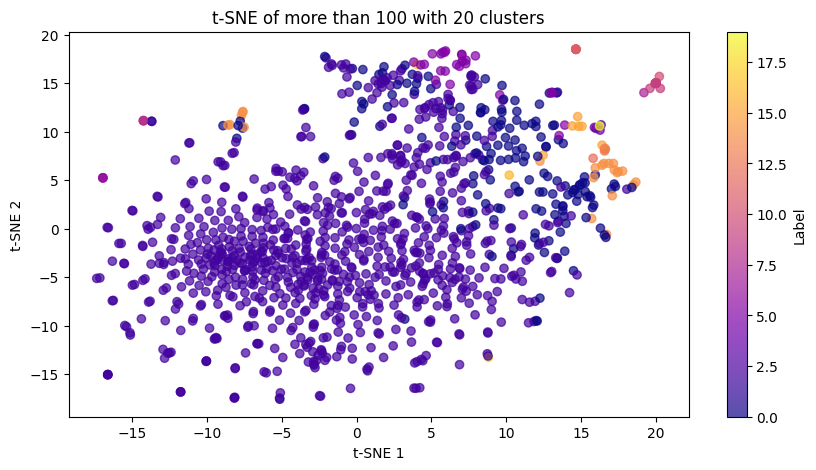

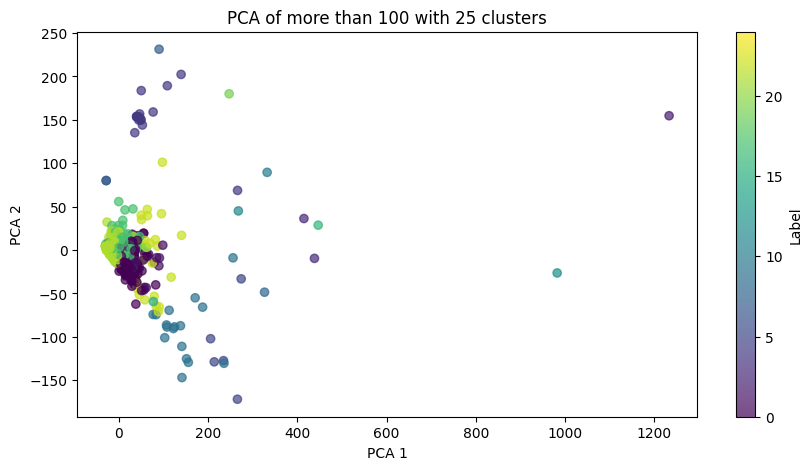

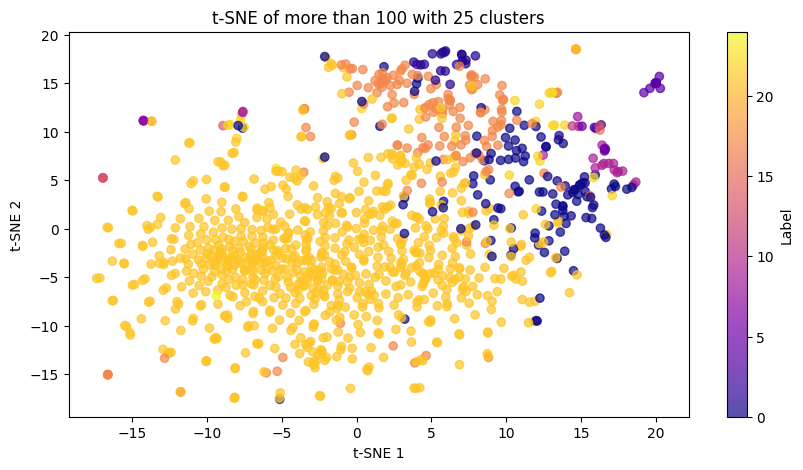

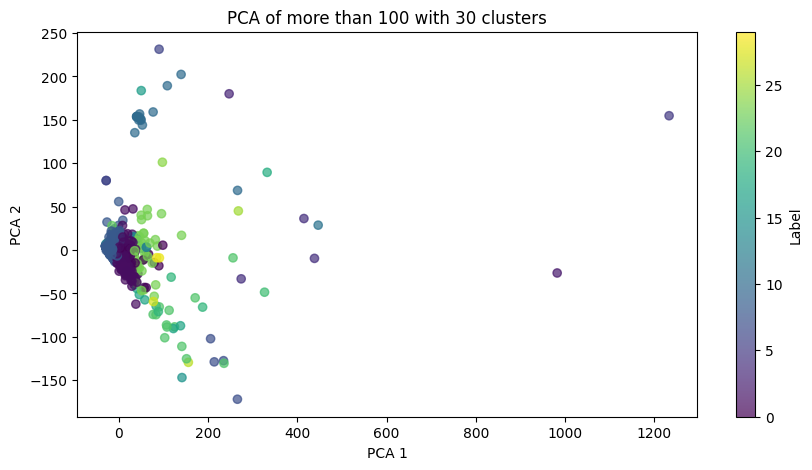

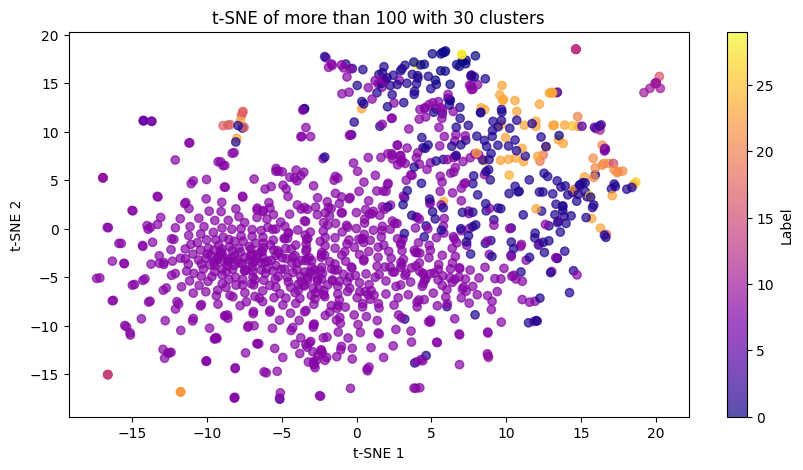

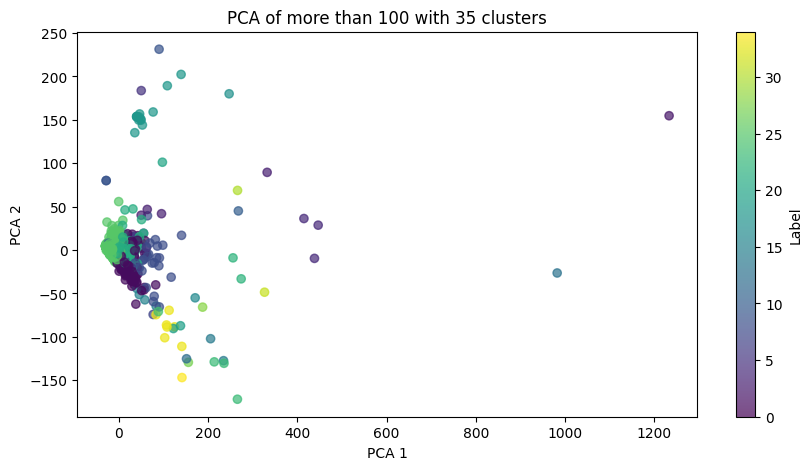

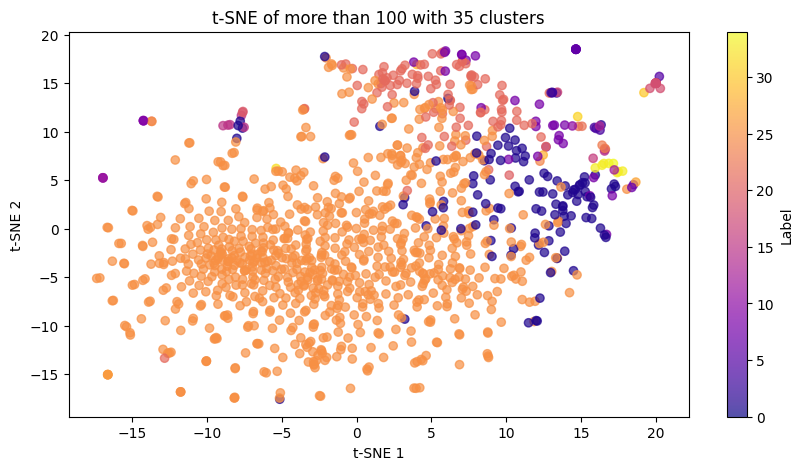

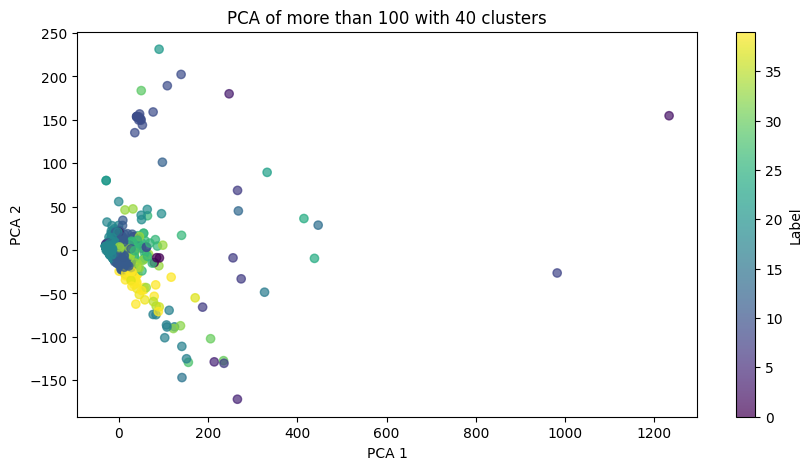

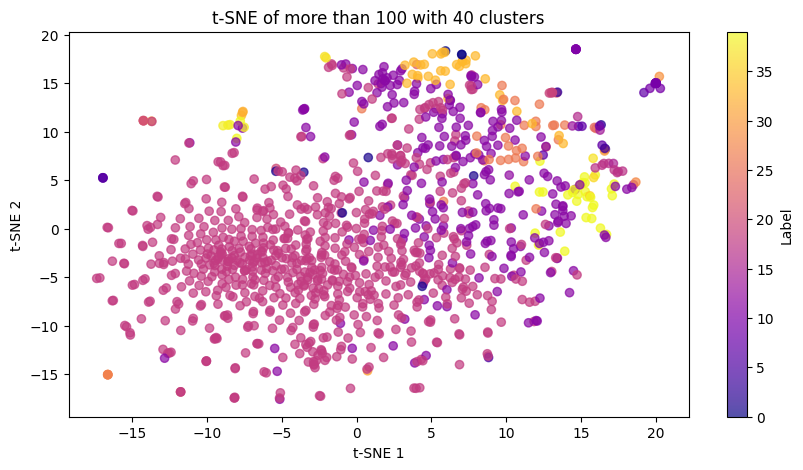

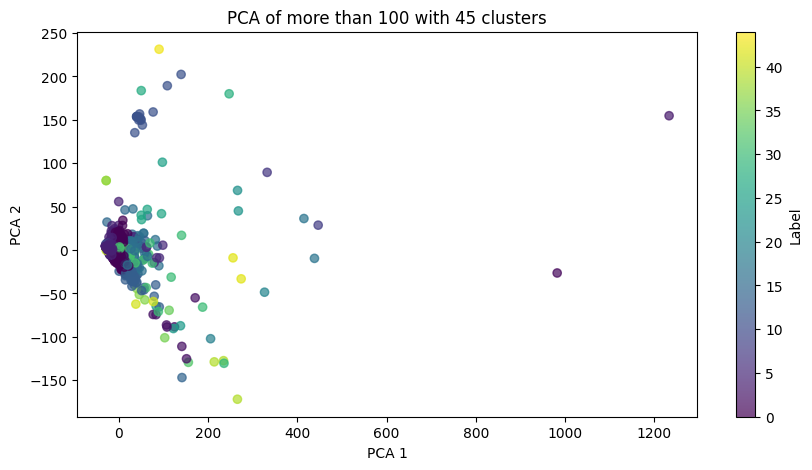

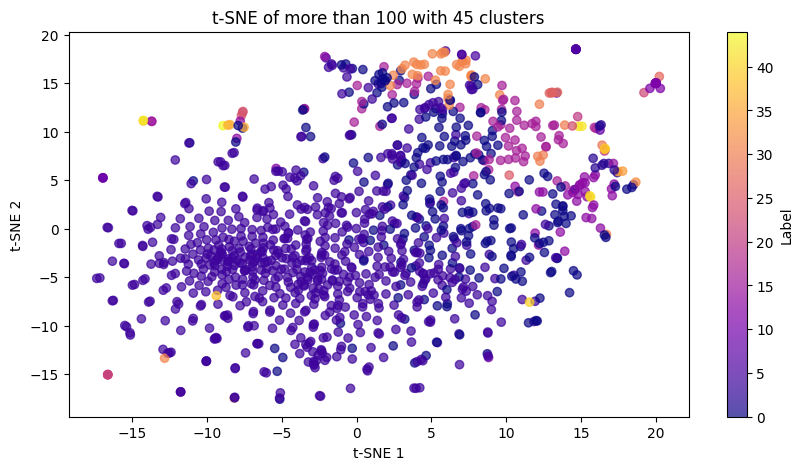

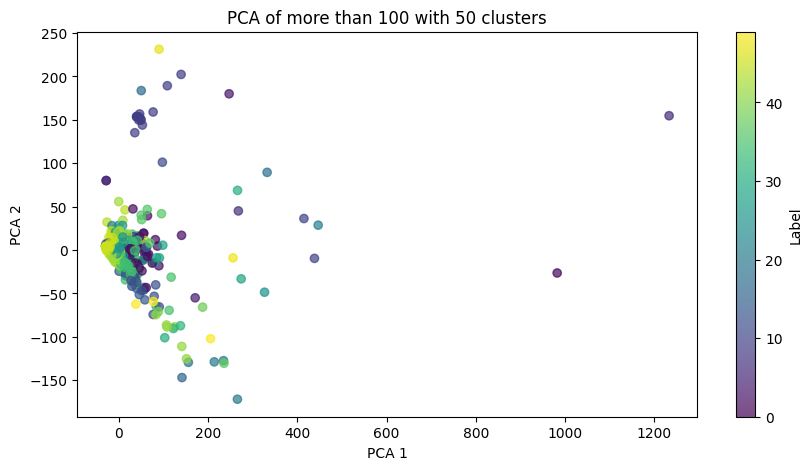

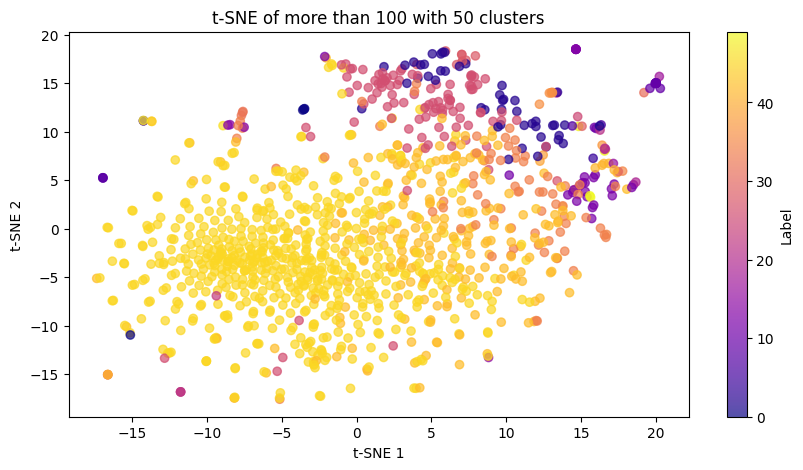

In [6]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def plot_pca(km, X, title):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X.toarray())
    plt.figure(figsize=(10, 5))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=km.labels_, cmap="viridis", alpha=0.7)
    plt.colorbar(label="Label")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.title(title)
    plt.show()

def plot_tsne(km, X, title):
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X.toarray())
    plt.figure(figsize=(10, 5))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=km.labels_, cmap="plasma", alpha=0.7)
    plt.colorbar(label="Label")
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.title(title)
    plt.show()

for i, km in enumerate(kms):
    for j, k in enumerate(km):
        if j % 5 == 0:
            plot_pca(k, get_bow_features(df_corporas[i]), f"PCA of {labels[i]} with {clusters_sizes[j]} clusters")
            plot_tsne(k, get_bow_features(df_corporas[i]), f"t-SNE of {labels[i]} with {clusters_sizes[j]} clusters")
